In [1]:
import tensorflow as tf
tf.enable_eager_execution()
import tensorflow.contrib.eager as tfe 

## Simple CNN

Here we create a simple convolutional neural network (CNN)to recognize hand-written digits (MNIST). We start by creating a simple alexnet CNN model. 

![alt text](https://i.imgur.com/twUKrlo.png)

In [2]:
from tensorflow.keras.layers import Dense, Convolution2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential

In [3]:
def create_model():
  model = Sequential()
  model.add(Convolution2D(filters = 16, kernel_size = 3, padding = 'same', input_shape = [28, 28, 1], activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2,2)))
  model.add(BatchNormalization())
  model.add(Convolution2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2,2)))
  model.add(BatchNormalization())
  model.add(Flatten())
  model.add(Dense(units = 100, activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(units = 10 , activation = 'softmax'))
  return model

In [4]:
model = create_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 16)        64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 32)          128       
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0         
__________

In [5]:
import numpy as np 
model(np.zeros((10,28,28,1), np.float32))

<tf.Tensor: id=221, shape=(10, 10), dtype=float32, numpy=
array([[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]], dtype=float32)>

## Load Mnist Data

In [6]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

## Look data 

The label is  5


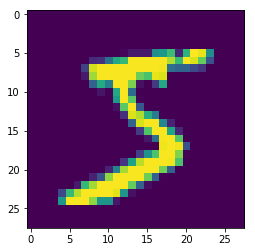

In [7]:
import matplotlib.pyplot as plt
print('The label is ',y_train[0])
plt.imshow(x_train[0])
plt.show()

## Preprocessing the dataset 

In [8]:
import numpy as np

N = x_train.shape[0]

#normalization and convert to batch input 
x_train = tf.expand_dims(np.float32(x_train)/ 255., 3)
x_test  = tf.expand_dims(np.float32(x_test )/ 255., 3)

#one hot encoding
y_train = tf.one_hot(y_train, 10)
y_test  = tf.one_hot(y_test , 10)

## Get Random Batch

In [9]:
import numpy as np
def get_batch(batch_size = 32):
  r = np.random.randint(0, N-batch_size)
  return x_train[r: r + batch_size], y_train[r: r + batch_size]

## Design the loss, gradient and accuract metric 

In [10]:
#evaluate the loss
def loss(model, x, y):
  prediction = model(x)
  return tf.losses.softmax_cross_entropy(y, logits=prediction)

#record the gradient with respect to the model variables 
def grad(model, x, y):
  with tf.GradientTape() as tape:
    loss_value = loss(model, x, y)
  return tape.gradient(loss_value, model.variables)

#calcuate the accuracy of the model 
def accuracy(model, x, y):
  
  #prediction
  yhat = model(x)
  
  #get the labels of the predicted values 
  yhat = tf.argmax(yhat, 1).numpy()
  
  #get the labels of the true values
  y    = tf.argmax(y   , 1).numpy()
  return np.sum(y == yhat)/len(y)

## Init

In [11]:
i = 1 

batch_size = 64 
epoch_length = N // batch_size
epoch = 0 
epochs = 5 

#use Adam optimizer 
optimizer = tf.train.AdamOptimizer()

#record epoch loss and accuracy  
loss_history = tfe.metrics.Mean("loss")
accuracy_history = tfe.metrics.Mean("accuracy")

## training

In [15]:
if tfe.num_gpus() > 0:
  with tf.device("/gpu:0"):    
    while epoch < epochs:
      #get next batch
      x, y = get_batch(batch_size = batch_size)

      # Calculate derivatives of the input function with respect to its parameters.
      grads = grad(model, x, y)

      # Apply the gradient to the model
      optimizer.apply_gradients(zip(grads, model.variables),
                                global_step=tf.train.get_or_create_global_step())

      #record the current loss and accuracy   
      loss_history(loss(model, x, y))
      accuracy_history(accuracy(model, x, y))

      if i % epoch_length == 0:
        print("epoch: {:d} Loss: {:.3f}, Acc: {:.3f}".format(epoch, loss_history.result(), accuracy_history.result()))

        #clear the history 
        loss_history.init_variables()
        accuracy_history.init_variables()

        epoch += 1

      i += 1
print("train complete")

train complete


## Testing

In [14]:
accuracy(model, x_test, y_test)

0.9848